In this notebook, we demonstrate how statistical tests work by working step-by-step through two tests.
We also show how to use scipy.stats to run the same tests in a single step.

In [41]:
# Useful imports
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Fix the random seed to make sure this notebook is reproducible.
np.random.seed(73473)

# Settings for plotting
%pylab inline

font = {'size'   : 18}
pyplot.rc('font', **font)
pyplot.rc('xtick', labelsize=14) 
pyplot.rc('ytick', labelsize=14)

Populating the interactive namespace from numpy and matplotlib


We start by creating two small sets of data, samples from normal distributions with mean 0 and 0.5, respectively. The first effect we want to measure is that the mean of the two distributions is not zero. 

Our null hypothesis is thus that the difference in the mean is 0, and we hope to be able to discard it.

The test that we will make manually, step-by-step, is known in the literature as t-test.

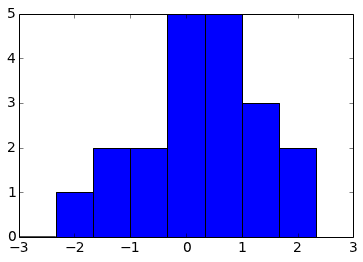

(-3, 3)

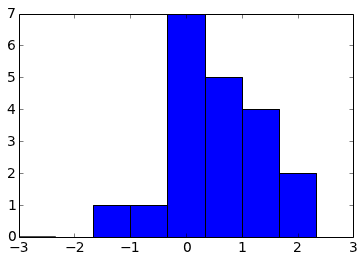

In [42]:
# Create the two data set, each with N points
N = 20
data_0 = stats.norm.rvs(loc=0.0, size=(N,))
data_1 = stats.norm.rvs(loc=0.5, size=(N,))

# We want to claim that their mean is not 0
mu0 = 0.0

# Show an histogram of the data points
pylab.rcParams['figure.figsize'] = (6.0, 4.0)
bins = np.linspace(-3, 3, 10)
_ = hist(data_0, bins=bins)
xlim([-3, 3])
show()
_ = hist(data_1, bins=bins)
xlim([-3, 3])

Step number two is specifying how we want to measure the effect. 
The statistic that we use is the difference of the sample mean from the null hypothesis mean, weighted by the standard error of the mean of the distribution. 
In other words, we're comparing the different from our estimate of the mean with the theoretical uncertainty of such an estimate (the SEM). The difference is measured in standard deviations of this uncertainty.

In [43]:
def t_statistics(data, mu0):
    mean_diff = data.mean(0) - mu0

    n_points = len(data)
    sem = data.std(ddof=1) / np.sqrt(n_points)

    t = mean_diff / sem

    return t

In [44]:
# Compute the statistics for our data set
t_0 = t_statistics(data_0, mu0)
print 't0 = ', t_0
t_1 = t_statistics(data_1, mu0)
print 't1 = ', t_1

t0 =  1.02696287762
t1 =  3.0790875397


The sample mean of the first population is 1.02 SEMs smaller than 0, and the one of the second population is 3.07 SEMs larger than 0... It sounds like a lot, but is it? We need to compare that with random populations drawn from the null hypothesis.

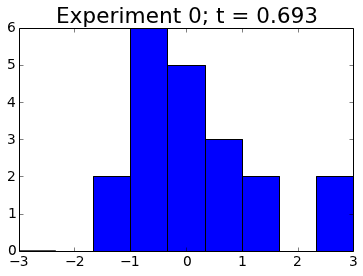

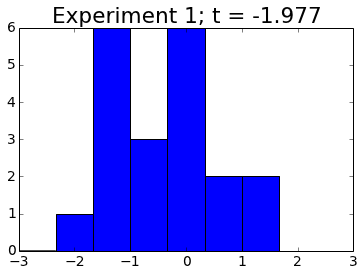

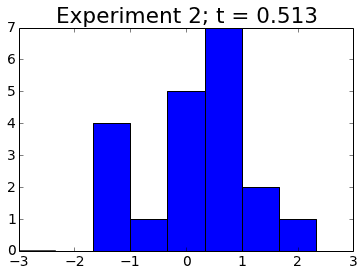

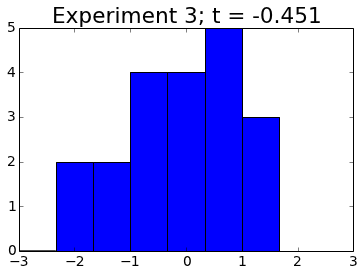

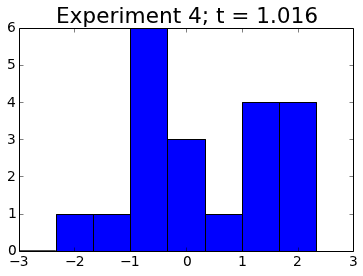

In [45]:
# Null hypothesis: the data has mean mu0
null_distr = stats.norm(loc=mu0)

# Show a few realizations from the null hypothesis.
for i in range(5):
    # Generate data from null distribution.
    x = null_distr.rvs(size=N)
    t = t_statistics(x, mu0)

    _ = hist(x, bins=np.linspace(-3, 3, 10))
    title('Experiment {}; t = {:.3f}'.format(i, t))
    xlim([-3, 3])
    show()

In [46]:
# Collect the means out of many realizations.
n_experiments = 500000

x = null_distr.rvs(size=(N, n_experiments))
means = x.mean(axis=0)

(-1.0, 1.0)

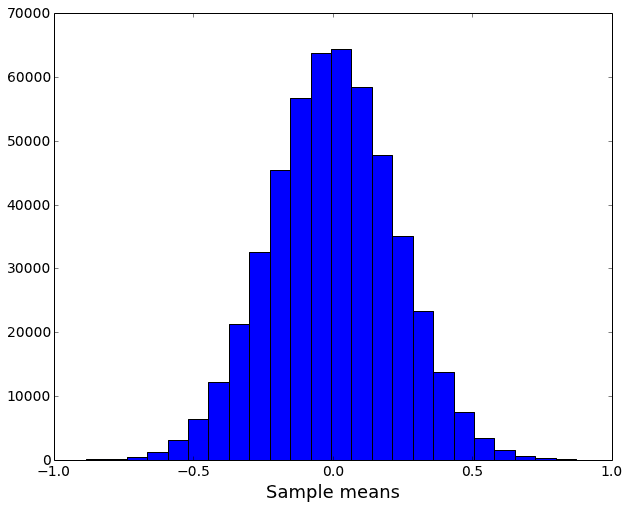

In [47]:
# Distribution of the sample means.
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
_ = hist(means, bins=30)
xlabel('Sample means')
xlim([-1.0, 1.0])

(-5.0, 5.0)

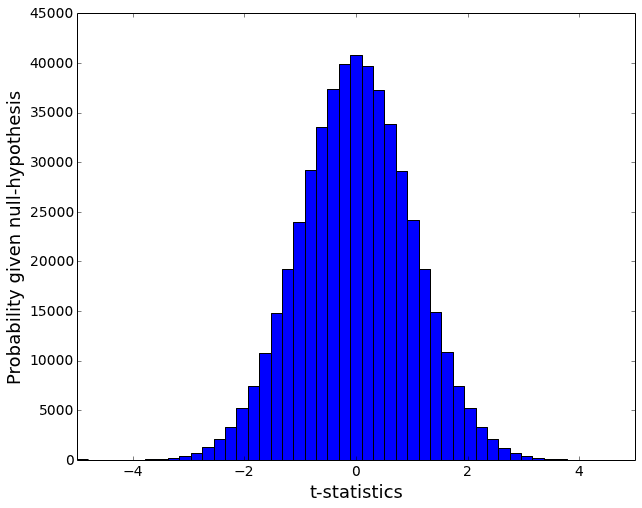

In [48]:
# Distribution of the statistics.
ts = t_statistics(x, mu0)

m = linspace(-5, 5, 50)
hist(ts, bins=m)
xlabel('t-statistics')
ylabel('Probability given null-hypothesis')
xlim([m[0], m[-1]])

We see that populations of size N=20 with zero mean can have t_statistics of 4 or more, just by chance.

It turns out that it is possible to derive this this distribution analytically: it's Student's t distribution.

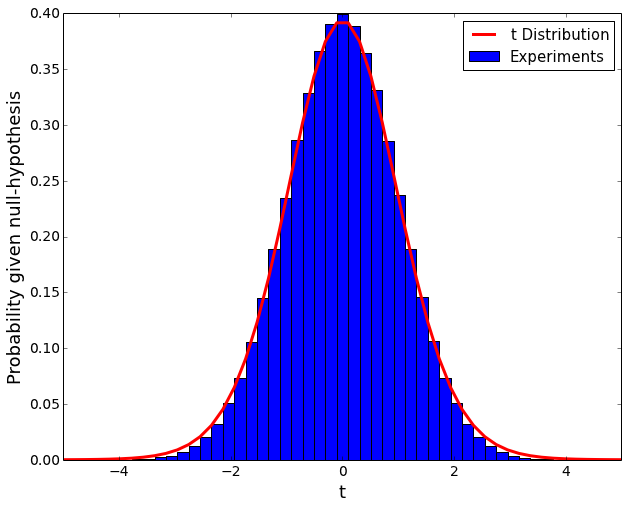

In [49]:
# Compare the t-distribution from scipy.stats with the distribution we found experimentally.
t_distr = stats.t(N-1)
_ = hist(ts, bins=m, normed=True)
_ = plot(m, t_distr.pdf(m), 'r', lw=3)
_ = xlim([m[0], m[-1]])
xlabel('t')
ylabel('Probability given null-hypothesis')

legend(['t Distribution', 'Experiments'], fontsize='small')

So, how unlikely are out population statistics?

In [50]:
print 'How common is the data statistics, assuming the null hypothesis?'
print 't0 = ', t_0
extrema = np.logical_or(ts < -abs(t_0), ts > abs(t_0)).sum()
print 'Fraction of time t_distr is as big as this', extrema / float(n_experiments)
print 'Using t-distribution', stats.t.sf(np.abs(t_0), N-1) * 2

print '\nt1 = ', t_1
extrema = np.logical_or(ts < -abs(t_1), ts > abs(t_1)).sum()
print 'Fraction of time t_distr is as big as this', extrema / float(n_experiments)
print 'Using t-distribution', stats.t.sf(np.abs(t_1), N-1) * 2


How common is the data statistics, assuming the null hypothesis?
t0 =  1.02696287762
Fraction of time t_distr is as big as this 0.304594
Using t-distribution 0.317335520332

t1 =  3.0790875397
Fraction of time t_distr is as big as this 0.002072
Using t-distribution 0.0061762213667


For the first distribution, we obtain a statistic of 1.03 or higher from the null hypothesis over 30% of the time. That's quite likely, and so we cannot discard the null hypothesis.

In the second case, the statistic is observable under the null hypothesis only 0.6% of the time, so we can feel confident that we can discard it.

Note that, since the t-distribution has long tails, it's more accurate to use the analytical formula directly, rather than the simulation results.

These steps correspond to the celebrated one-sample t-test, which is available in scipy.stats .

In [51]:
t0, p = stats.ttest_1samp(data_0, mu0)
print 't0 = ', t0
print 'p-value = ', p
# p-value =  0.317 => Cannot reject null-hypthesis.

t1, p = stats.ttest_1samp(data_1, mu0)
print 't1 = ', t1
print 'p-value = ', p
# p-value =  0.006 => Reject null-hypothesis, the statistics value is unusual.


t0 =  1.02696287762
p-value =  0.317335520332
t1 =  3.0790875397
p-value =  0.0061762213667


We would like to make a new claim about the difference in the mean between the two populations. The null hypothesis is that there is no difference at all. This corresponds to the two-samples t-test.

In [52]:
t, p = stats.ttest_ind(data_0, data_1)
print 't = ', t
print 'p-value = ', p
# p-value =  0.313 => Cannot reject null-hypthesis.

t =  -1.021761168
p-value =  0.313355055263


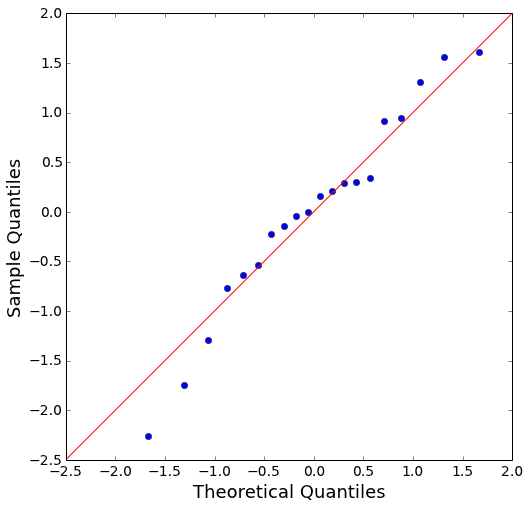

In [53]:
# Are the t-test assumptions satisfied?
# Normality, same variance.

pylab.rcParams['figure.figsize'] = (8.0, 8.0)

pp_0 = sm.ProbPlot(data_0, dist=stats.norm, fit=True)
fig = pp_0.qqplot(line='45')

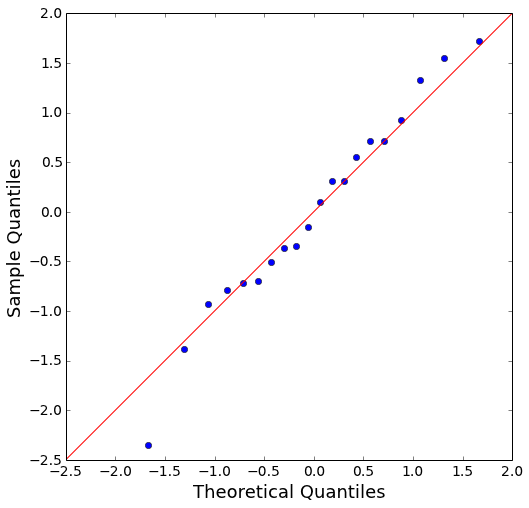

In [54]:
pp_1 = sm.ProbPlot(data_1, dist=stats.norm, fit=True)
fig = pp_1.qqplot(line='45')

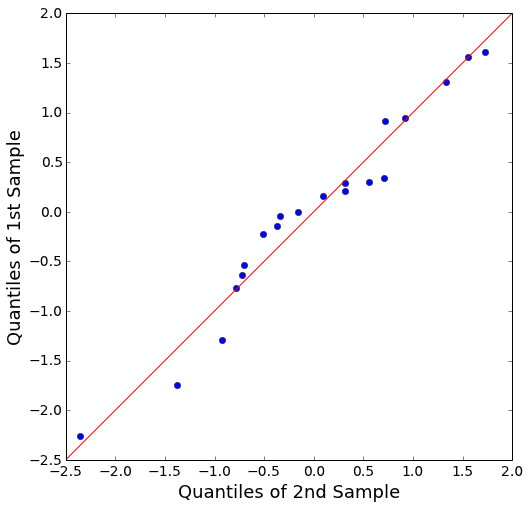

In [55]:
fig = pp_0.qqplot(line='45', other=pp_1)